# Physics 8820
## Learning from Data: Bayesian Methods and Machine Learning
### Autumn, 2021
$% Some LaTeX definitions we'll use.
\newcommand{\pr}{\textrm{p}}
$

## Mini-project IIIb: Bayesian Neural Networks

**Answer questions and do tasks written in boldface.**

Based on the `demo-Bayesian_neural_networks_tif285.ipynb` notebook by Christian Forssén, which in turn was based on:

### Variational Inference: Bayesian Neural Networks

(c) 2016-2018 by Thomas Wiecki, updated by Maxim Kochurov.

Original blog post: https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/
and updated version: https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html.

This mini-project relies on the following additional packages:
* `theano`: Theano is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently, featuring tight integration with NumPy, transparent use of a GPU, efficient symbolic differentiation, speed and stability optimizations and dynamic C code generation.
* `pymc3`: PyMC3 is a library for probabilistic programming in python. It allows you to write down models using an intuitive syntax to describe a data generating process.
* `arviz`: ArviZ (pronounced "AR-vees") is a Python package for exploratory analysis of Bayesian models. Includes functions for posterior analysis, model checking, comparison and diagnostics.

This should work with conda environments using the original environment.yml conda file on Macs and Linux machines or using the environment_windows.yml conda file on Windows 10.


### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable. Here we use `make_moons` from scikit-learn to generate the full set of data (see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) and `train_test_split` to divide it into training and test sets (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_context("talk")

from warnings import filterwarnings
filterwarnings('ignore')

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles

In [2]:
# Import theano and pymc3

# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"  # Is this is really necessary?
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T

In [3]:
# Create combined training and test data.  For other examples, see
#  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
X, Y = make_moons(noise=0.2, random_state=2, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)

# Split into training and test data. test_size is proportion in test data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5, 
                                                    random_state=0)

**To do: add code here to plot the training and test data in the empty two plots below.**

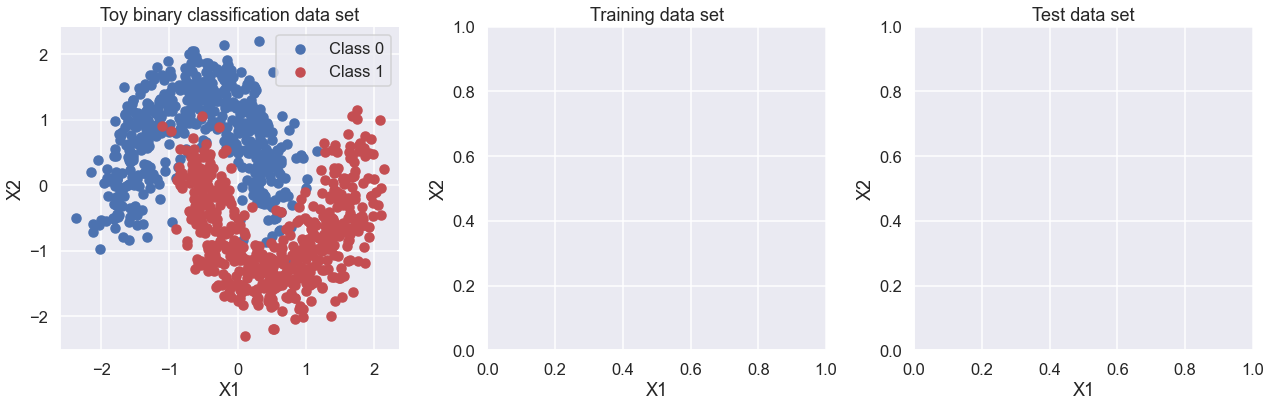

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

ax[0].scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax[0].legend()
ax[0].set(xlabel='X1', ylabel='X2', title='Toy binary classification data set')

ax[1].set(xlabel='X1', ylabel='X2', title='Training data set')

ax[2].set(xlabel='X1', ylabel='X2', title='Test data set')


fig.tight_layout()

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron), which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we start with 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5   # this is the number of neurons, not hidden layers

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data 
        # container pm.Data.  It's still the same thing, but we can later 
        # change the values of the shared variable (to switch in the test-data 
        # later) and pymc3 will just use the new data. Like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to 1st hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from 2nd hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh( pm.math.dot(ann_input, weights_in_1) )
        act_2 = pm.math.tanh( pm.math.dot(act_1, weights_1_2) )
        act_out = pm.math.sigmoid( pm.math.dot(act_2, weights_2_out) )

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs (come back to do this later).

### Variational Inference: Scaling model complexity

To find a posterior for the weights, we will use [ADVI](https://arxiv.org/abs/1603.00788) variational inference algorithm in PyMC3. This is much faster than an MCMC sampler and will scale better.

**Note**, however, that this is a mean-field approximation so we **ignore correlations** in the posterior.

In [6]:
from pymc3.theanof import set_tt_rng
np.random.seed(42)
set_tt_rng(42)


In [7]:
%%time

# Run the ADVI inference for n iterations.
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Finished [100%]: Average Loss = 104.96


CPU times: user 32.8 s, sys: 1.06 s, total: 33.9 s
Wall time: 14.9 s


Plotting the objective function (ELBO) shows us how the optimization of the fit improves over time.

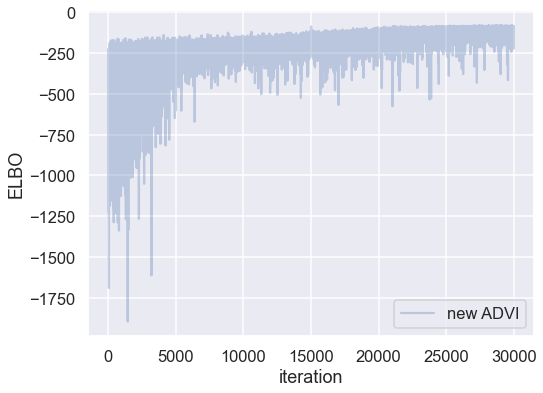

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(-inference.hist, label='new ADVI', alpha=.3)
ax.legend()
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration')
plt.tight_layout;

Now that we have trained our model, lets predict on the hold-out (i.e., test) set using a posterior predictive check (PPC). 
1. We can use `sample_posterior_predictive() <../api/inference.rst>`__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
1. It is better to get the node directly and build theano graph using our approximation (approx.sample_node) , we get a lot of speed up.  We'll use this method below.

In [9]:
# We can get predicted probability from model
neural_network.out.distribution.p

sigmoid.0

In [10]:
# create symbolic input in theano
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Let’s go ahead and generate predictions (using method 2 from above):
pred = sample_proba(X_test, 500).mean(0) > 0.5


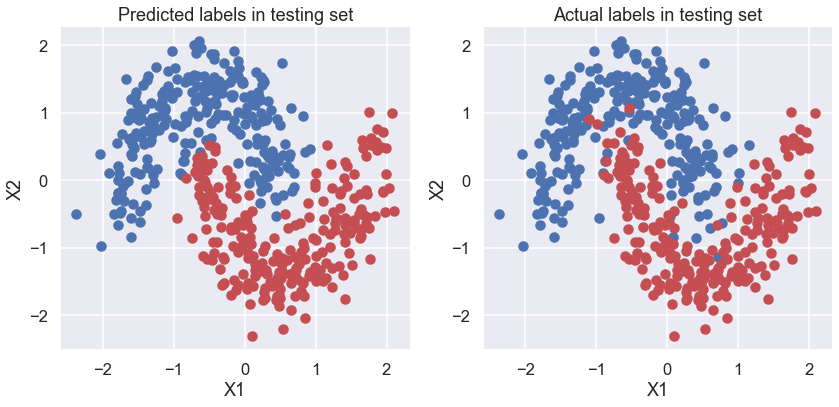

In [11]:
# Make plots of predicted and actual labels
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax[0].scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax[0].set(title='Predicted labels in testing set', xlabel='X1', ylabel='X2');

ax[1].scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
ax[1].scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
sns.despine()
ax[1].set(title='Actual labels in testing set', xlabel='X1', ylabel='X2');


fig.tight_layout()

In [12]:
# accuracy of predictions
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.19999999999999%


## Let's look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [13]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [14]:
ppc = sample_proba(grid_2d ,500)

### Probability surface

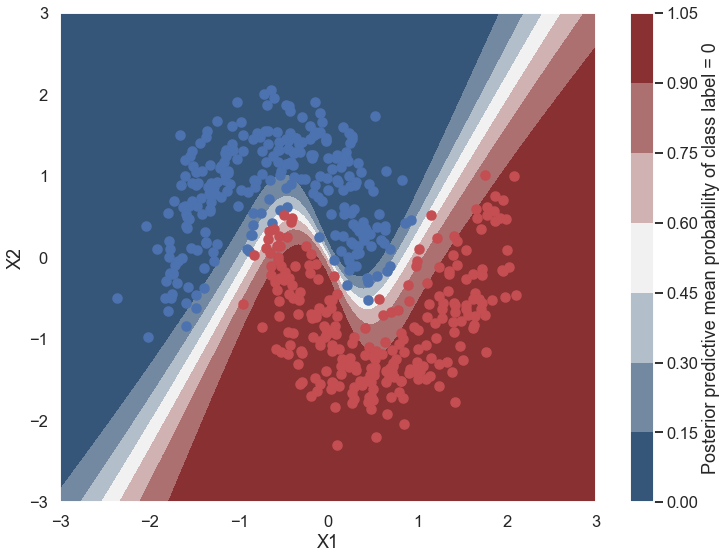

In [15]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

**What is being plotted in this graph?  How does it compare to what you would get from a non-Bayesian neural network?**

### Uncertainty in predicted value

**What is being plotted below?  Why is this different from a non-Bayesian neural network?**

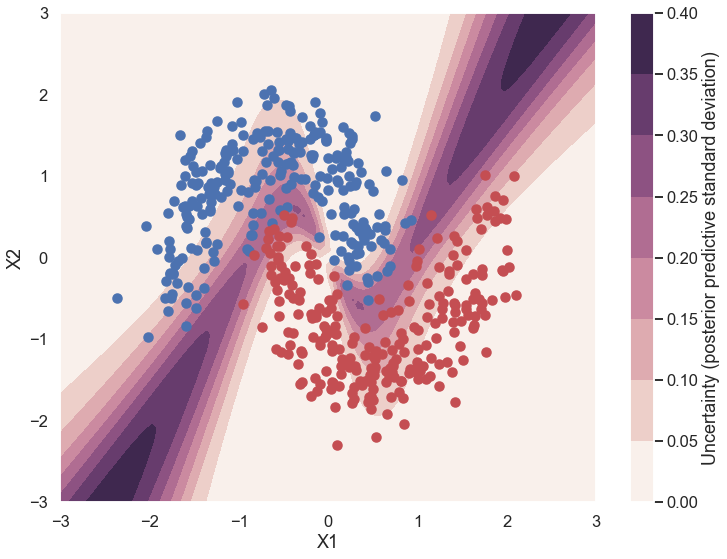

In [16]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## To do

**For each of the parameter choices listed below, do the following:** 

**a. Predict from the training and test data plots how well the Bayesian neural network should do (e.g., compared to the other parameter choices).**

**b. Record the Average Loss.  Does the optimization appear to be converged?** 

**c. Record the accuracy.  Is the value consistent with your expectations from a.?**

**d. What does the "uncertainty in predicted value" figure tell you about where the uncertainty in picking a label (red or blue) is greatest for this case?  Consider both regions where there is a lot of training data and where there is no training data.  Why does this make sense given your expectations from a.?**


### Parameter choices

#### 1. `n_samples = 1000`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 30000`

    a.

    b.

    c.

    d.

#### 2. `n_samples = 1000`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 60000`

    a.

    b.

    c.

    d.

#### 3. `n_samples = 1000`, `noise = 0.05`, `test_size = 0.5`, iterations `n = 60000`

    a.

    b.

    c.

    d.

#### 4. `n_samples = 1000`, `noise = 0.5`, `test_size = 0.5`, iterations `n = 60000`

    a.

    b.

    c.

    d.
    

#### 5. `n_samples = 100`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 60000`

    a.

    b.

    c.

    d.
    


**Copy below the code for the `construct_nn` function that adds a third hidden layer to the neural network. Test it on one of the parameter choices above, and describe how the results b., c., and d. compare for two and three hidden layers.** 

In [17]:
### Copy code for construct_nn function with 3rd hidden layer





**For a plus: copy below the modified code for the `construct_nn` function that adds a bias to each set of weights. Test it on one of the parameter choices above, and describe how the results b., c., and d. compare with and without the biases.** **   

In [18]:
### Copy code for construct_nn function with biases


